In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [3]:
csv_path = "covid_jabar_perkembangan_harian.csv"
df = pd.read_csv(csv_path)

print("Kolom yang tersedia:")
print(df.columns)
df.head()


Kolom yang tersedia:
Index(['tanggal', 'kode_kab_kota', 'nama_kab_kota', 'konfirmasi_total', 'konfirmasi_sembuh', 'konfirmasi_meninggal',
       'konfirmasi_aktif', 'konfirmasi_total_daily_growth', 'konfirmasi_sembuh_daily_growth',
       'konfirmasi_meninggal_daily_growth', 'konfirmasi_aktif_daily_growth', 'kota_kab_belum_teridentifikasi',
       'sembuh_unidentified', 'meninggal_unidentified', 'id'],
      dtype='object')


,tanggal,kode_kab_kota,nama_kab_kota,konfirmasi_total,konfirmasi_sembuh,konfirmasi_meninggal,konfirmasi_aktif,konfirmasi_total_daily_growth,konfirmasi_sembuh_daily_growth,konfirmasi_meninggal_daily_growth,konfirmasi_aktif_daily_growth,kota_kab_belum_teridentifikasi,sembuh_unidentified,meninggal_unidentified,id
0,2020-03-01 00:00:00,32,jawa barat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
1,2020-03-01 00:00:00,3204,Kabupaten Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2
2,2020-03-01 00:00:00,3217,Kabupaten Bandung Barat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,3
3,2020-03-01 00:00:00,3216,Kabupaten Bekasi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4
4,2020-03-01 00:00:00,3201,Kabupaten Bogor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,5


In [4]:
df["tanggal"] = pd.to_datetime(df["tanggal"])

df_group = (
    df.groupby("tanggal", as_index=False)["konfirmasi_aktif"]
      .sum()
      .sort_values("tanggal")
      .reset_index(drop=True)
)

df_group.head()

,tanggal,konfirmasi_aktif
0,2020-03-01,2.0
1,2020-03-02,2.0
2,2020-03-03,1.0
3,2020-03-04,3.0
4,2020-03-05,3.0


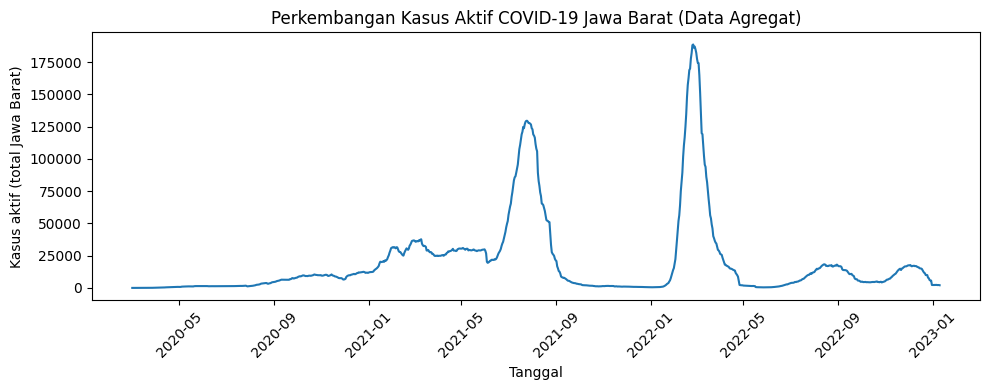

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(df_group["tanggal"], df_group["konfirmasi_aktif"])
plt.xlabel("Tanggal")
plt.ylabel("Kasus aktif (total Jawa Barat)")
plt.title("Perkembangan Kasus Aktif COVID-19 Jawa Barat (Data Agregat)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
df_used = df_group[df_group["konfirmasi_aktif"].notna()].copy()
df_used = df_used.reset_index(drop=True)

print("Jumlah hari data yang tersedia:", len(df_used))
df_used.head()

Jumlah hari data yang tersedia: 1046


,tanggal,konfirmasi_aktif
0,2020-03-01,2.0
1,2020-03-02,2.0
2,2020-03-03,1.0
3,2020-03-04,3.0
4,2020-03-05,3.0


In [7]:
# 5. Estimasi parameter r secara sederhana dari data

I_data = df_used["konfirmasi_aktif"].values.astype(float)

# Ambil hanya titik dengan I > 0 untuk menghindari log(0)
mask_pos = I_data > 0
I_pos = I_data[mask_pos]

if len(I_pos) < 2:
    raise ValueError("Data positif terlalu sedikit untuk estimasi r.")

# Hitung pertumbuhan relatif harian: ln(I_{n+1} / I_n)
growth_logs = np.log(I_pos[1:] / I_pos[:-1])
r_est = growth_logs.mean()  # rata-rata pertumbuhan log

I0 = I_pos[0]  # nilai awal model dari data positif pertama

print("I0 (nilai awal dari data):", I0)
print("Estimasi r (rata-rata log growth per hari):", r_est)


I0 (nilai awal dari data): 2.0
Estimasi r (rata-rata log growth per hari): 0.006645059529406244


In [8]:
# 6. Definisi model ODE dan fungsi Metode Euler

def f_exp(t, I, params):
    """
    Model eksponensial: dI/dt = r * I
    params: dict yang minimal berisi 'r'
    """
    r = params["r"]
    return r * I


def euler_solve(f, t0, y0, h, n_steps, params):
    """
    Menyelesaikan ODE 1D dengan Metode Euler.

    f      : fungsi ODE f(t, y, params)
    t0     : waktu awal
    y0     : nilai awal
    h      : step size (langkah waktu)
    n_steps: jumlah langkah
    params : parameter model (dict)
    """
    t_values = np.zeros(n_steps + 1)
    y_values = np.zeros(n_steps + 1)

    t_values[0] = t0
    y_values[0] = y0

    for n in range(n_steps):
        y_values[n+1] = y_values[n] + h * f(t_values[n], y_values[n], params)
        t_values[n+1] = t_values[n] + h

    return t_values, y_values


In [9]:
# 7. Menjalankan simulasi Euler dengan model eksponensial

h = 1.0  # 1 hari per langkah
n_days = len(df_used)
n_steps = n_days - 1  # karena titik awal sudah terhitung sebagai hari ke-0

params = {"r": r_est}
t0 = 0.0

t_sim, I_sim = euler_solve(f_exp, t0, I0, h, n_steps, params)

# Samakan panjang dengan data
I_data_used = df_used["konfirmasi_aktif"].values.astype(float)[: len(I_sim)]
tanggal_used = df_used["tanggal"].values[: len(I_sim)]

# Gabungkan ke satu DataFrame
df_result = pd.DataFrame({
    "tanggal": tanggal_used,
    "I_data": I_data_used,
    "I_euler": I_sim
})

df_result.head()


,tanggal,I_data,I_euler
0,2020-03-01,2.0,2.000000
1,2020-03-02,2.0,2.013290
2,2020-03-03,1.0,2.026669
3,2020-03-04,3.0,2.040136
4,2020-03-05,3.0,2.053693


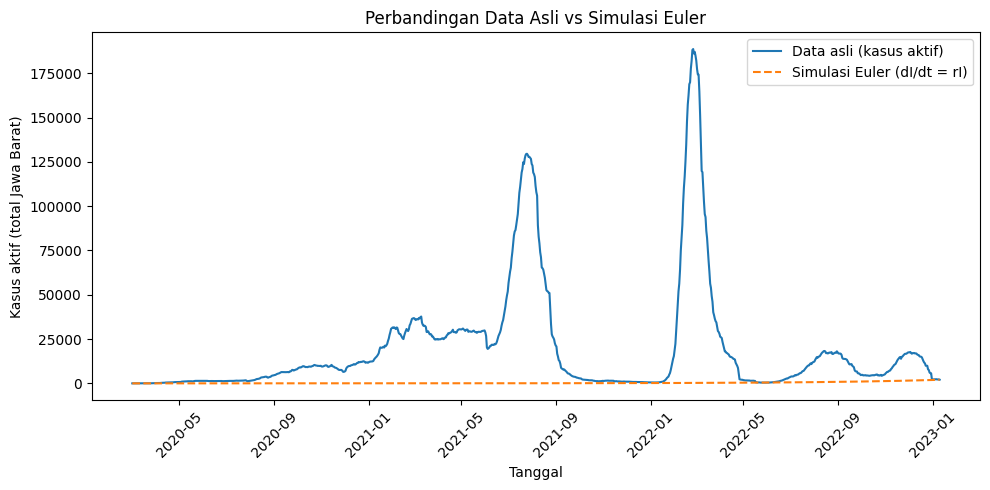

In [10]:
# 8. Plot data vs hasil simulasi Euler

plt.figure(figsize=(10, 5))
plt.plot(df_result["tanggal"], df_result["I_data"], label="Data asli (kasus aktif)")
plt.plot(df_result["tanggal"], df_result["I_euler"], "--", label="Simulasi Euler (dI/dt = rI)")
plt.xlabel("Tanggal")
plt.ylabel("Kasus aktif (total Jawa Barat)")
plt.title("Perbandingan Data Asli vs Simulasi Euler")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
